In [1]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import plot_importance
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)

In [2]:
identifier_name = 'flight_id'

most_important_features_names = [
    'wtc', 
    'flown_distance', 
    'aircraft_type', 
    'groundspeed_max', 
    'groundspeed_75percentile', 
    'altitude_25percentile', 
    'airline', 
    'longitude_max', 
    'latitude_min', 
    'flight_duration', 
    'vertical_rate_std', 
    'altitude_median', 
    'longitude_mean', 
    'altitude_75percentile', 
    'longitude_std', 
    'latitude_max', 
    'latitude_std', 
    'vertical_rate_max', 
    'vertical_rate_25percentile', 
    'latitude_mean', 
    'longitude_min', 
    'longitude_25percentile', 
    'ades', 
    'adep', 
    'country_code_adep', 
    'vertical_rate_75percentile', 
    'latitude_median', 
    'altitude_mean', 
    'latitude_25percentile', 
    'country_code_ades', 
    'month_day', 
    'actual_offblock_time_hour', 
    'groundspeed_min', 
    'longitude_75percentile', 
    'vertical_rate_median'
]

target_name = 'tow'

global_random_state = 123

In [3]:
encoded_challenge_set = pd.read_csv('data/encoded_challenge_set.csv')

features = encoded_challenge_set[most_important_features_names].copy()
display(features)

target = encoded_challenge_set[[target_name]].copy()
display(target)

,wtc,flown_distance,aircraft_type,groundspeed_max,groundspeed_75percentile,altitude_25percentile,airline,longitude_max,latitude_min,flight_duration,vertical_rate_std,altitude_median,longitude_mean,altitude_75percentile,longitude_std,latitude_max,latitude_std,vertical_rate_max,vertical_rate_25percentile,latitude_mean,longitude_min,longitude_25percentile,ades,adep,country_code_adep,vertical_rate_75percentile,latitude_median,altitude_mean,latitude_25percentile,country_code_ades,month_day,actual_offblock_time_hour,groundspeed_min,longitude_75percentile,vertical_rate_median
0,1,321,4,390.0,368.0,9550.00,20,-0.443802,51.453232,61,1609.709745,26175.0,-4.817843,32000.0,2.655620,52.028643,0.161396,5568.0,-704.0,51.837035,-8.574295,-7.346304,79,69,37,368.0,51.892997,20991.546763,51.774945,34,0,13,102.0,-2.418875,0.0
1,0,4193,18,495.0,484.0,33000.00,10,2.097078,25.803905,570,691.174222,33000.0,-37.864321,38000.0,32.832625,43.390968,6.193836,3328.0,0.0,36.416839,-80.492389,-66.559062,165,216,33,0.0,35.748230,29599.616239,31.443732,78,0,9,109.0,-4.094342,0.0
2,0,3770,7,470.0,406.0,24275.00,18,17.939514,41.965164,554,687.891983,36000.0,-33.600731,36000.0,43.183849,63.104782,8.598085,3072.0,0.0,54.653675,-88.239066,-85.001760,168,137,88,0.0,60.114143,29266.370244,44.087809,78,0,9,89.0,7.996781,0.0
3,0,3607,21,478.0,460.0,30000.00,10,8.637296,39.524386,497,670.081295,38000.0,-36.308858,39975.0,33.535859,54.923820,4.887211,4224.0,-64.0,47.313159,-75.200562,-69.237322,169,338,19,0.0,47.763176,32681.139500,42.496536,78,0,11,104.0,-2.139416,-64.0
4,1,305,1,498.0,430.0,7025.00,20,0.029984,51.464942,55,1609.815425,16850.0,-2.412936,31000.0,2.100484,53.426793,0.731746,4224.0,-896.0,52.449270,-6.399455,-4.134391,58,92,44,768.0,52.485926,17836.102603,51.682892,27,0,12,123.0,-0.433886,-256.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369008,0,4046,21,521.0,477.0,28768.75,10,2.558947,25.811234,545,870.857796,34000.0,-40.831541,36975.0,34.354707,49.090393,9.563126,4160.0,-64.0,38.877157,-80.441687,-69.023288,165,253,36,0.0,34.402197,29688.784438,32.045397,78,364,9,137.0,-4.419947,-64.0
369009,1,946,1,426.0,395.0,30787.50,14,28.944917,41.182114,158,856.019220,34000.0,21.168711,34025.0,4.738333,52.425594,3.546660,3584.0,-64.0,47.262027,13.501244,17.159999,15,385,96,0.0,47.335968,29129.706377,44.200717,19,364,9,101.0,25.316283,0.0
369010,1,522,4,381.0,336.0,20368.75,20,6.777954,51.266816,99,1231.417354,35975.0,0.286890,36000.0,4.047513,53.728592,0.735722,3840.0,-64.0,52.913110,-6.267151,-3.278382,80,30,26,64.0,53.203024,27860.307460,52.352230,34,364,9,93.0,3.818993,0.0
369011,1,466,1,473.0,365.0,15243.75,20,2.556927,48.985199,84,1352.690507,35375.0,-1.596933,36000.0,2.960105,53.421707,1.257386,4096.0,-640.0,51.544348,-6.276566,-4.379273,80,253,36,64.0,51.519921,26310.734017,50.848103,34,364,9,103.0,1.370786,0.0


,tow
0,54748.000000
1,185441.000000
2,230396.000000
3,157615.000000
4,70318.447226
...,...
369008,163438.000000
369009,78707.000000
369010,62942.750000
369011,72611.161024


In [4]:
# Function to score model using Root Mean Square Error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
# Create a scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Make cross validation strategy
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=global_random_state)

In [5]:
param_grid = {
    'n_estimators': np.arange(1000, 10001, 1000),  # From 1 to 200, step by 10
}

model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    eval_metric='rmse',
    random_state=global_random_state,
    colsample_bytree=1.0,
    learning_rate=0.1, 
    max_depth=10, 
    subsample=1.0
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error', # Use RMSE (negative because scikit-learn maximizes scores)
    cv=cv_strategy,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(features, target)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=1.0,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    in...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=10, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=123, ...),
             n_jobs=-1,
             param_grid={'n_estimators': array([ 1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000,
       10000])},
             scoring='neg_root_mean_squared_error', verbose=2)

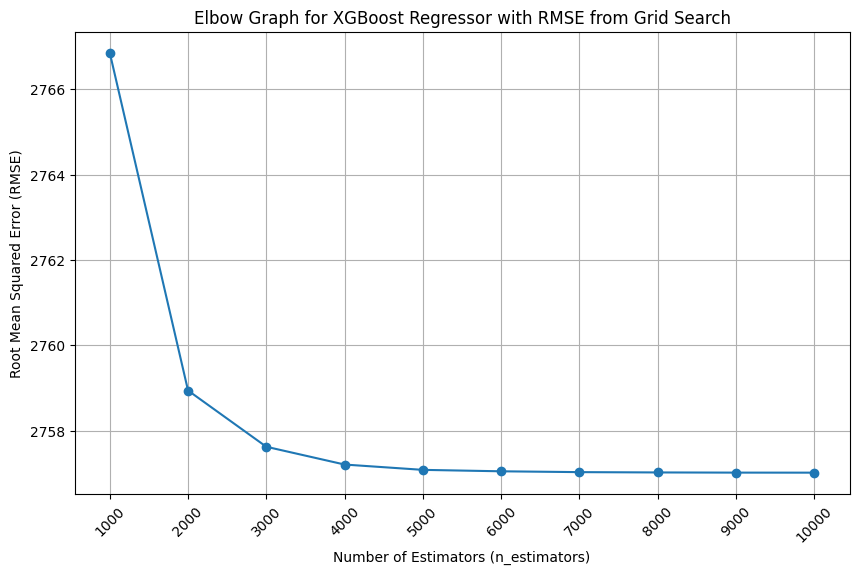

Best Parameters: {'n_estimators': 10000}
Best RMSE: 2757.013594881173


In [6]:
results = grid_search.cv_results_

rmse_values = -results['mean_test_score']

plt.figure(figsize=(10, 6))
plt.plot(results['param_n_estimators'], rmse_values, marker='o')
plt.title('Elbow Graph for XGBoost Regressor with RMSE from Grid Search')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.xticks(results['param_n_estimators'], rotation=45)
plt.grid()
plt.show()

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)

In [7]:
print(results['param_n_estimators'])

[1000 2000 3000 4000 5000 6000 7000 8000 9000 10000]


In [8]:
print(rmse_values)

[2766.85876518 2758.9391344  2757.62074832 2757.2037955  2757.07907821
 2757.04544947 2757.0259064  2757.01867862 2757.01461556 2757.01359488]
